In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"  # Set the GPU device to use (0, 1, etc.)
import matplotlib.pyplot as plt
from create_data.create_turbulent_2D import generate_correlated_lognormal_field
import time
import jax
import jax.numpy as jnp
from jax import random, vmap
from functools import partial
import numpy as np

In [2]:
@partial(jax.jit, static_argnames=["num_rays", "step_size", "max_steps"])
def compute_radiation_field_from_star(j_map, kappa_map, source_pos, num_rays=360, step_size=0.5, max_steps=1000):
    """
    Emit rays from a point source in all directions and compute the radiation field J(x, y).

    Args:
        j_map: 2D emissivity field
        kappa_map: 2D absorption field
        source_pos: (x0, y0) position of the star
        num_rays: number of directions to shoot
        step_size: marching step
        max_steps: max steps per ray

    Returns:
        J: 2D array of accumulated intensity per cell
    """
    Nx, Ny = j_map.shape
    J = jnp.zeros((Nx, Ny))

    # Sample directions uniformly over 2π
    angles = jnp.linspace(0, 2 * jnp.pi, num_rays, endpoint=False)
    directions = jnp.stack([jnp.cos(angles), jnp.sin(angles)], axis=1)
    
    @jax.jit
    def trace_and_accumulate(direction):
        def body_fn(i, state):
            x, y, I, tau, J = state

            # Clamp to grid
            ix = jnp.clip(jnp.floor(x).astype(int), 0, Nx - 1)
            iy = jnp.clip(jnp.floor(y).astype(int), 0, Ny - 1)

            j_val = j_map[ix, iy]
            kappa_val = kappa_map[ix, iy]

            ds = step_size
            d_tau = kappa_val * ds
            dI = j_val * jnp.exp(-tau) * ds

            I_new = I + dI
            tau_new = tau + d_tau

            # Update radiation field
            J = J.at[ix, iy].add(dI)

            x_new = x + direction[0] * ds
            y_new = y + direction[1] * ds

            return (x_new, y_new, I_new, tau_new, J)

        # Initial state
        x0, y0 = source_pos
        initial = (x0, y0, 0.0, 0.0, J)
        _, _, _, _, J_new = jax.lax.fori_loop(0, max_steps, body_fn, initial)
        return J_new

    J_all = jax.vmap(trace_and_accumulate)(directions)

    return jnp.sum(J_all, axis=0)


def compute_radiation_field_from_multiple_stars(
    j_map, kappa_map, source_positions,
    num_rays=360, step_size=0.5, max_steps=1000
):
    """
    Compute radiation field J(x, y) from multiple point sources.

    Args:
        j_map: 2D emissivity field
        kappa_map: 2D absorption field
        source_positions: list or array of (x, y) star positions
        num_rays: rays per star
        step_size: ray marching step
        max_steps: steps per ray

    Returns:
        J: total radiation field from all sources
    """
    J_total = jnp.zeros_like(j_map)
    mean_J  = 0
    for source_pos in source_positions:
        J_single = compute_radiation_field_from_star(
            j_map, kappa_map, source_pos,
            num_rays=num_rays,
            step_size=step_size,
            max_steps=max_steps
        )
        J_total += J_single
        mean_J  += jnp.mean(J_single)
        
    return J_total


def gaussian_emissivity(Nx, Ny, center, amplitude=1e3, width=5.0):
    """
    Generate a 2D Gaussian emissivity profile centered at a given position.

    Args:
        Nx, Ny: grid size
        center: (x0, y0) position of the source
        amplitude: peak intensity
        width: standard deviation (in pixels)

    Returns:
        emissivity: 2D array (Nx, Ny)
    """
    X, Y = jnp.meshgrid(jnp.arange(Nx), jnp.arange(Ny), indexing='ij')
    x0, y0 = center
    r2 = (X - x0)**2 + (Y - y0)**2
    return amplitude * jnp.exp(-r2 / (2 * width**2))


In [3]:
def create_data_2d(key, shape):
    # Generate an emissivity fields
    Nx, Ny = shape
    
    kappa, mask = generate_correlated_lognormal_field(key, shape=(Nx, Ny), mean=1.0, length_scale=0.05, sigma_g=1.2, percentile = 99)

    # Extract coordinates of top 1% (True values in mask)
    def fixed_argwhere(mask):  # change 400 to non hardcoded-value 
        #size = Nx * Ny * 0.01
        coords = jnp.argwhere(mask, size=400)
        return coords 
    star_indices = fixed_argwhere(mask)

    star_positions = star_indices.astype(jnp.float32) + 0.5  # (x, y) coords

    emissivity = jnp.zeros((Nx, Ny))

    def pos_loop(state, pos):
        emissivity = state 
        return emissivity + gaussian_emissivity(Nx, Ny, center=pos, amplitude=1e3, width=5.0), None

    emissivity, _ = jax.lax.scan(pos_loop, emissivity, star_positions)

    J_multi = compute_radiation_field_from_multiple_stars(
        emissivity, kappa, star_positions,
        num_rays=360, step_size=0.2, max_steps=1500
        )
    return jnp.stack([kappa, emissivity, J_multi])

# should we also return x and y coordinates of grid? - at the moment probably not necessary because always same grid
# create_data_2d_vmapped = jax.vmap(create_data_2d)

In [4]:
key = random.PRNGKey(0)
keys = random.split(key, 1000)

def create_data(keys):
    return create_data_2d(keys, (200, 200))

data = jax.lax.map(create_data, keys, batch_size=25)

In [5]:
data.shape

(1000, 3, 200, 200)

In [6]:
np.save('mein_array.npy', data)

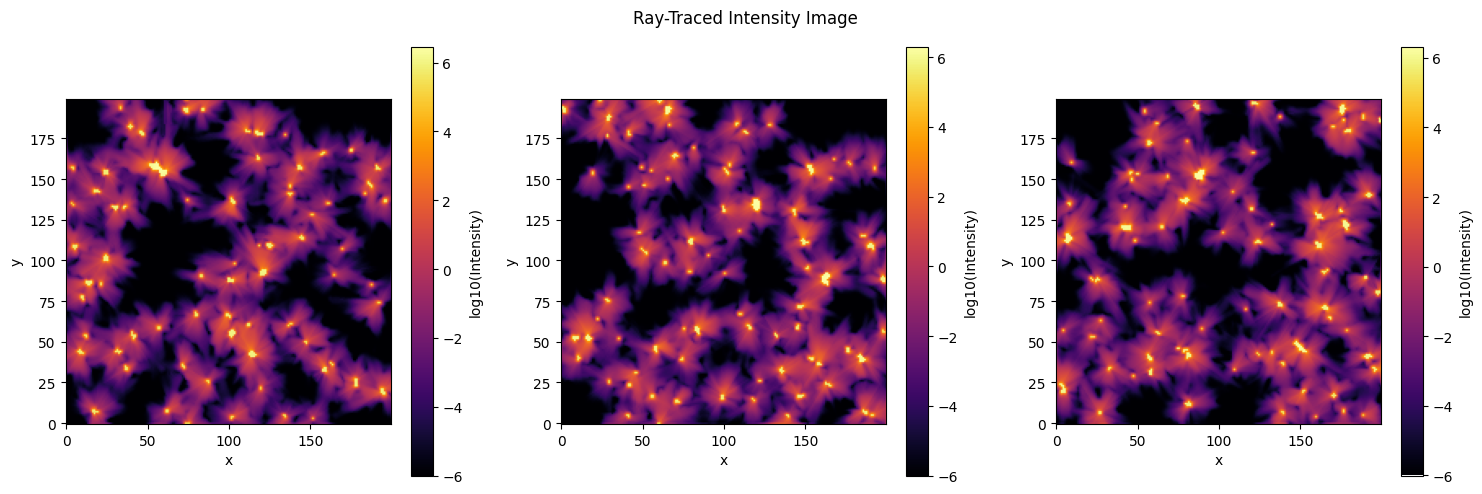

In [7]:
plt.figure(figsize=(15, 5))
#plt.imshow(jnp.log10(data[57,2,:,:] + 1e-6), origin='lower', cmap='inferno')
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(jnp.log10(data[i,2,:,:] + 1e-6), origin='lower', cmap='inferno')
    plt.colorbar(label="log10(Intensity)")
    plt.xlabel("x")
    plt.ylabel("y")

plt.suptitle("Ray-Traced Intensity Image")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()
